In [1]:
import numpy as np
import librosa
import IPython.display as ipd

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn.functional as F

from torchvision.utils import make_grid  # |   Utility stuff for plotting
import matplotlib.pyplot as plt          # |  <- I use this one a lot for plotting, seaborn is a good alternative
from matplotlib.image import imread      # |  it reads images... (png -> usable input (like a numpy array for ex))
import os
import random
from tqdm import tqdm  # | This one is a cute one for making a loading bar, I like it and we'll use it here

In [5]:
#load the CREMA-D AudioWAV dataset and dataloader
def load_dataset(directory, batch_size):
    dataset = []
    max_len = 0
    for filename in os.listdir(directory):
        if(filename.endswith('.wav')):
            filepath  = os.path.join(directory, filename)
            emotion_label = filename.split('_')[2]
            audio_tensor, _ = librosa.load(filepath, sr=None)
            max_len = max(max_len, len(audio_tensor))
            audio_tensor = torch.tensor(audio_tensor, dtype=torch.float32)
            dataset.append([audio_tensor, emotion_label])

    dataset = [(torch.nn.functional.pad(audio_tensor, (0, max_len - audio_tensor.size(0))), label)
                      for audio_tensor, label in dataset]

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
            
    return dataset, dataloader

In [19]:
crema_d_directory = "./AudioWAV"
dataset, dataloader = load_dataset(crema_d_directory, batch_size=32)
ex_audio, ex_label = dataset[random.randint(0,20)]

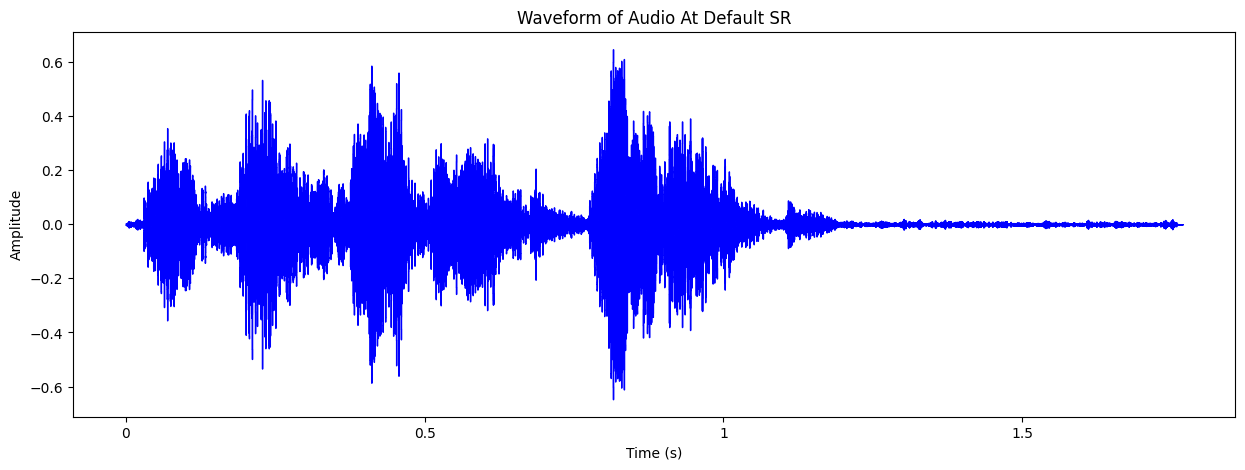

In [14]:
# This code shows you the waveform of a sample from the dataset
# Different sampling rates can affect the audio
v_path = './AudioWAV/1001_IEO_HAP_HI.wav'
audio , sampling_rate = librosa.load(v_path)
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio , sr = sampling_rate, color="blue")
ipd.Audio(v_path)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio At Default SR')

plt.show()

Text(0.5, 1.0, 'Waveform of Audio At SR=1000')

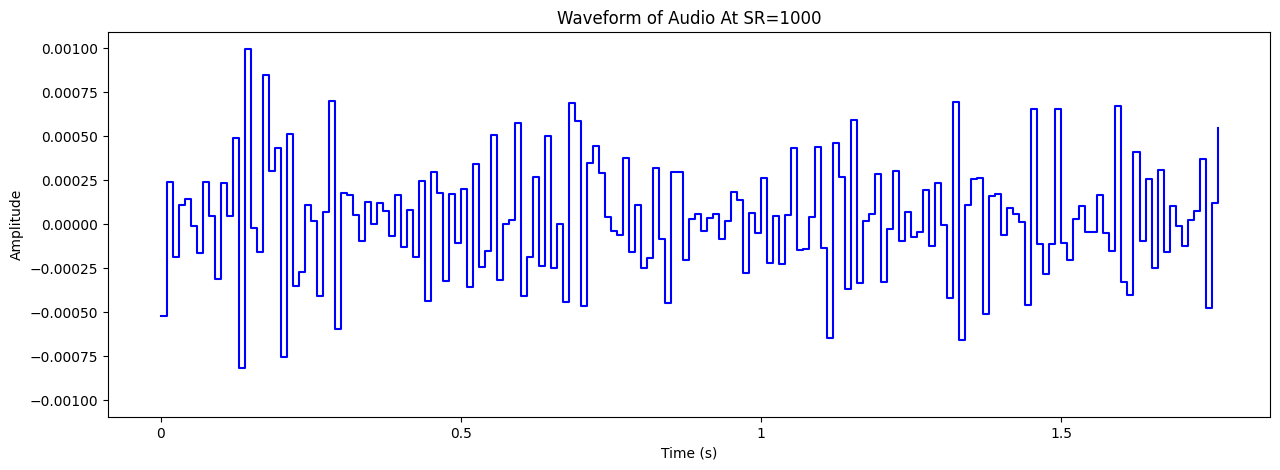

In [16]:
SAMPLE_RATE = 100
v_path = './AudioWAV/1001_IEO_HAP_HI.wav'
audio , sampling_rate = librosa.load(v_path,sr=SAMPLE_RATE)
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio , sr = sampling_rate, color="blue")
ipd.Audio(v_path,rate=1000)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio At SR=1000')

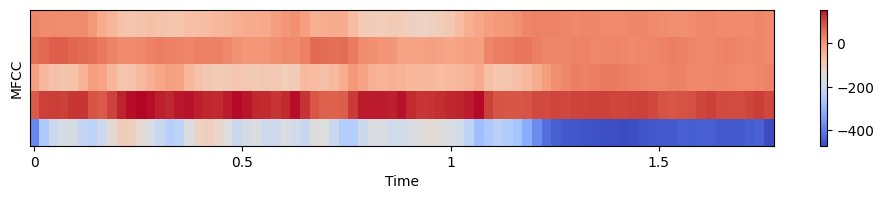

In [21]:
SAMPLE_RATE = 22050
v_path = './AudioWAV/1001_IEO_HAP_HI.wav'
audio , sampling_rate = librosa.load(v_path,sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc = 5)
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

In [16]:
class MyCNN(nn.Module):

    def __init__(self, input_size, output_size):
        super(MyCNN, self).__init__()

        self.input_size = input_size 
        self.conv1 = nn.Conv2d(1, 5, (7,7))
        self.conv2 = nn.Conv2d(5, 10, (5,5))

        self.relu = nn.ReLU()      
        cnn_out_size = 18*18*10     

        self.mlp = MyMLP(cnn_out_size, output_size) 


    def forward(self, x):

        x = x.view(-1, 1, 28, 28) 

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)

        self.filtered = out  
        out = out.flatten()  
        out = self.mlp(out)  

        return out